In [105]:
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
import sklearn.svm as svm
import pandas as pd
import warnings

In [106]:
from featureExtraction import *
from dataAnalyzer import *
from private_tool import *
from dataHandler import *

In [107]:
warnings.filterwarnings('ignore')

In [108]:
experimentNum = 9
experimentIdx = 4
Experiments = [MotorImageryDataset(parentDirectory(dir=currDir, separator="\\", n=1)+'/bcicompetitionIV2a/A0'+str(i+1)+'T.npz') for i in range(experimentNum)]

In [109]:
channels = list(range(25))
samplingRate = 250 #Hz
trialsByClasses = np.array([i.get_trials_by_classes(channels=channels) for i in Experiments])

In [110]:
channelNum = len(channels)
m = len(trialsByClasses[0]["left"])
channelNum, m

(25, 25)

In [111]:
bandpassedTrialsByClasses = [{i:[[] for _ in range(channelNum)] for i in j.mi_types.values()} for j in Experiments]
for k in range(experimentNum):
    for key in trialsByClasses[k].keys():
        for i in range(channelNum):
            bandpassedTrialsByClasses[k][key][i] = np.array([bandpass_filter(data=trialsByClasses[k][key][i][j], 
                                                                sample_rate=samplingRate, 
                                                                cutoff_low=7, 
                                                                cutoff_high=30)\
                                                for j in range(len(trialsByClasses[k][key][i]))])

In [112]:
# 현재 상태는 experiment - class - channel - trial - signal
# class - experiment - trial - channel - signal로 수정하자
bandpassedTrialsByClasses = {key: np.array([[bandpassedTrialsByClasses[i][key][j] for j in range(channelNum)] for i in range(experimentNum)]) for key in Experiments[0].mi_types.values()}
# bandpassedTrialsByClasses["left"][8][0].shape
# i: experiment
# j: trial

In [113]:
minTrialsNum = sorted([sorted([len(bandpassedTrialsByClasses["left"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["right"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["tongue"][i][0]) for i in range(experimentNum)])[0], sorted([len(bandpassedTrialsByClasses["foot"][i][0]) for i in range(experimentNum)])[0]])[0]
bandpassedTrialsByClasses = {i:[bandpassedTrialsByClasses[i][j] for j in range(experimentNum)] for i in Experiments[0].mi_types.values()}
minTrialsNum

49

In [114]:
left_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["left"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
right_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["right"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
tongue_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["tongue"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "tongue", "foot"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))
foot_csp_filter = CSP_filter(np.array([i[:minTrialsNum] for i in bandpassedTrialsByClasses["foot"][experimentIdx]]), np.array([j[:minTrialsNum] for i in ["left", "right", "tongue"] for j in bandpassedTrialsByClasses[i][experimentIdx]]))

In [115]:
bandpassedTrials = {i:[] for i in Experiments[0].mi_types.values()}
for i in Experiments[0].mi_types.values():
    for j in range(len(bandpassedTrialsByClasses)):
        bandpassedTrials[i]

In [116]:
# CSP_passed_left_data = np.array([[bandpassedTrialsByClasses[i][j].T@left_csp_filter for j in range(minTrialsNum)] for i in range(experimentNum)])
CSP_passed_left_data = [j[:minTrialsNum].T@left_csp_filter for j in bandpassedTrialsByClasses["left"][experimentIdx]]
CSP_passed_right_data = [j[:minTrialsNum].T@right_csp_filter for j in bandpassedTrialsByClasses["right"][experimentIdx]]
CSP_passed_tongue_data = [j[:minTrialsNum].T@tongue_csp_filter for j in bandpassedTrialsByClasses["tongue"][experimentIdx]]
CSP_passed_foot_data = [j[:minTrialsNum].T@foot_csp_filter for j in bandpassedTrialsByClasses["foot"][experimentIdx]]

In [117]:
len(CSP_passed_left_data)

25

In [118]:
# bandpassedTrialsByClasses["right"][0]["right"][0]

In [119]:
CSP_passed_left_data = [np.array([j.T for j in i]).T for i in CSP_passed_left_data]
CSP_passed_right_data = [np.array([j.T for j in i]).T for i in CSP_passed_right_data]
CSP_passed_tongue_data = [np.array([j.T for j in i]).T for i in CSP_passed_tongue_data]
CSP_passed_foot_data = [np.array([j.T for j in i]).T for i in CSP_passed_foot_data]
np.array(CSP_passed_left_data).shape

(25, 49, 1875)

In [120]:
CSP_passed_left_data = np.array([i.T for i in np.array(CSP_passed_left_data).T]).T
CSP_passed_right_data = np.array([i.T for i in np.array(CSP_passed_right_data).T]).T
CSP_passed_tongue_data = np.array([i.T for i in np.array(CSP_passed_tongue_data).T]).T
CSP_passed_foot_data = np.array([i.T for i in np.array(CSP_passed_foot_data).T]).T
CSP_passed_left_data.shape

(49, 25, 1875)

In [121]:
m = 3

leftVarRatioDF = log_variance(CSP_passed_left_data, 0, channelNum, minTrialsNum, m)
rightVarRatioDF = log_variance(CSP_passed_right_data, 1, channelNum, minTrialsNum, m)
tongueVarRatioDF = log_variance(CSP_passed_tongue_data, 2, channelNum, minTrialsNum, m)
footVarRatioDF = log_variance(CSP_passed_foot_data, 3, channelNum, minTrialsNum, m)

VarRatioDF = pd.concat([leftVarRatioDF, rightVarRatioDF, tongueVarRatioDF, footVarRatioDF], axis=0)
VarRatioDF.columns = [f"{n}" for n in range(m*2)] + ["target"]
labelDF = VarRatioDF.reset_index().iloc[:, -1]

In [122]:

x = VarRatioDF.drop(['target'], axis=1).values 
y = VarRatioDF['target'].values # 종속변인 추출
x = StandardScaler().fit_transform(x)
pd.DataFrame(x)

,0,1,2,3,4,5,6,7
0,-1.498989,-2.186883,-0.382475,-2.658824,-0.004662,1.502982,1.528069,0.606349
1,-1.119851,1.123292,0.730853,0.444682,1.398329,-0.237661,0.412700,0.412774
2,-0.309644,-0.324485,0.386834,0.372212,0.943769,0.210739,0.919372,0.879370
3,-1.553052,-0.922355,-0.777590,0.324806,-0.370649,0.846370,1.858520,0.183162
4,-0.975686,0.848807,0.647577,1.712289,1.269625,0.773789,0.404596,1.138732
...,...,...,...,...,...,...,...,...
191,-0.597995,0.934740,0.714015,-1.408700,-0.113427,0.442501,0.235985,0.066200
192,0.956234,1.589268,0.192301,2.011833,0.938523,-0.340202,-0.572104,-0.016324
193,1.428284,-1.432423,-1.066228,-1.070670,-2.399793,-2.474525,-1.364984,-1.310509
194,0.211177,-0.658072,0.701611,-1.331686,-0.182070,-0.518782,-0.476509,0.429240


In [123]:
n_componunts = 5
PCA = PrincipalComponuntAnalysis(n_componunts=n_componunts, data=x)
principalDF = PCA.principalDf

In [124]:
sum(PCA.explained_variance_ratio_())

0.9092269619491661

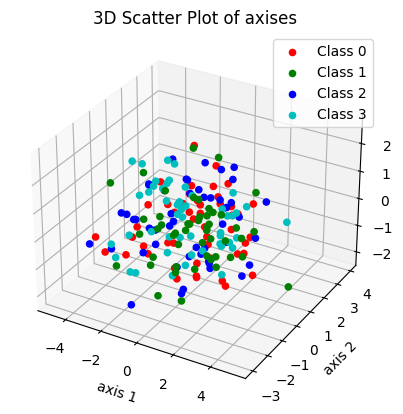

,axis1,axis2,axis3,axis4,axis5,label
0,-2.616035,-2.977222,0.525316,1.019724,1.431679,0
1,-1.290764,1.606837,0.460455,-0.379863,-0.349734,0
2,-1.487791,0.267589,0.360985,-0.458678,-0.256620,0
3,-1.824121,-0.659856,-1.067607,-0.421126,1.611977,0
4,-1.817116,2.089201,-0.156334,-0.779619,-0.152591,0
...,...,...,...,...,...,...
191,-0.620204,0.146345,0.401536,1.433373,0.104982,3
192,0.682789,2.296580,-0.505799,-0.669855,-1.373321,3
193,3.767636,-2.495012,0.215048,-0.550963,0.273453,3
194,0.226083,-0.962323,1.347740,0.352098,-0.195711,3


In [125]:
# 데이터를 DataFrame으로 생성
df = pd.concat([principalDF, labelDF], axis=1)
plotDF3D(df ,4)
df

In [126]:
LDA_DF = pd.concat([pd.DataFrame(LDATransform(principalDF, labelDF, 3, "eigen")), labelDF], axis=1)

In [127]:
LDA_DF.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [128]:
scaler = StandardScaler()
scaler.fit(LDA_DF.loc[:, :"axis3"])
LDA_DF_Scaled = pd.concat([pd.DataFrame(scaler.transform(LDA_DF.loc[:, :"axis3"])), labelDF], axis=1)
LDA_DF_Scaled.columns = [f"axis{i+1}" for i in range(3)] + ["label"]

In [130]:
# SVM, kernel = 'linear'로 선형분리 진행
svm_clf =svm.SVC(kernel = 'linear', random_state=100)

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

# SVM, kernel = 'rbf'로 비선형분리 진행
svm_clf = svm.SVC(kernel = 'rbf')

# 교차검증
scores = cross_val_score(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv = 5)
scores

pd.DataFrame(cross_validate(svm_clf, LDA_DF_Scaled.loc[:, :"axis3"], labelDF, cv =5))

print('교차검증 평균: ', scores.mean())

교차검증 평균:  0.29615384615384616
교차검증 평균:  0.3417948717948718
